Dataset hosted by Kaggle  
URL: https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction  

The aim of this project will be to develop variouis classfication models which will be able to predict whether a company will face bankruptcy in the future  

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report,confusion_matrix,f1_score,accuracy_score,recall_score,precision_score

In [44]:
# Importing the data

In [45]:
df = pd.read_csv('Data/data.csv')

In [46]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [48]:
df.isna().sum().value_counts()
# No missing values 

0    96
dtype: int64

In [49]:
# Applying the log transformation to the data which suffers from the greatest amount of skewness

In [50]:
bank = df['Bankrupt?']
def log_transform(data):
    data.drop('Bankrupt?',axis=1,inplace=True)
    for col in data:
        skewness = data[col].skew()
        if skewness > 0.5 or skewness < -0.5 and col != 'Bankrupt?':
            data[col] = np.log1p(data[col])
        else:
            continue
    return data

df = log_transform(df)
df['Bankrupt?'] = bank

In [51]:
# Creating a horizontal boxplot of all the available data

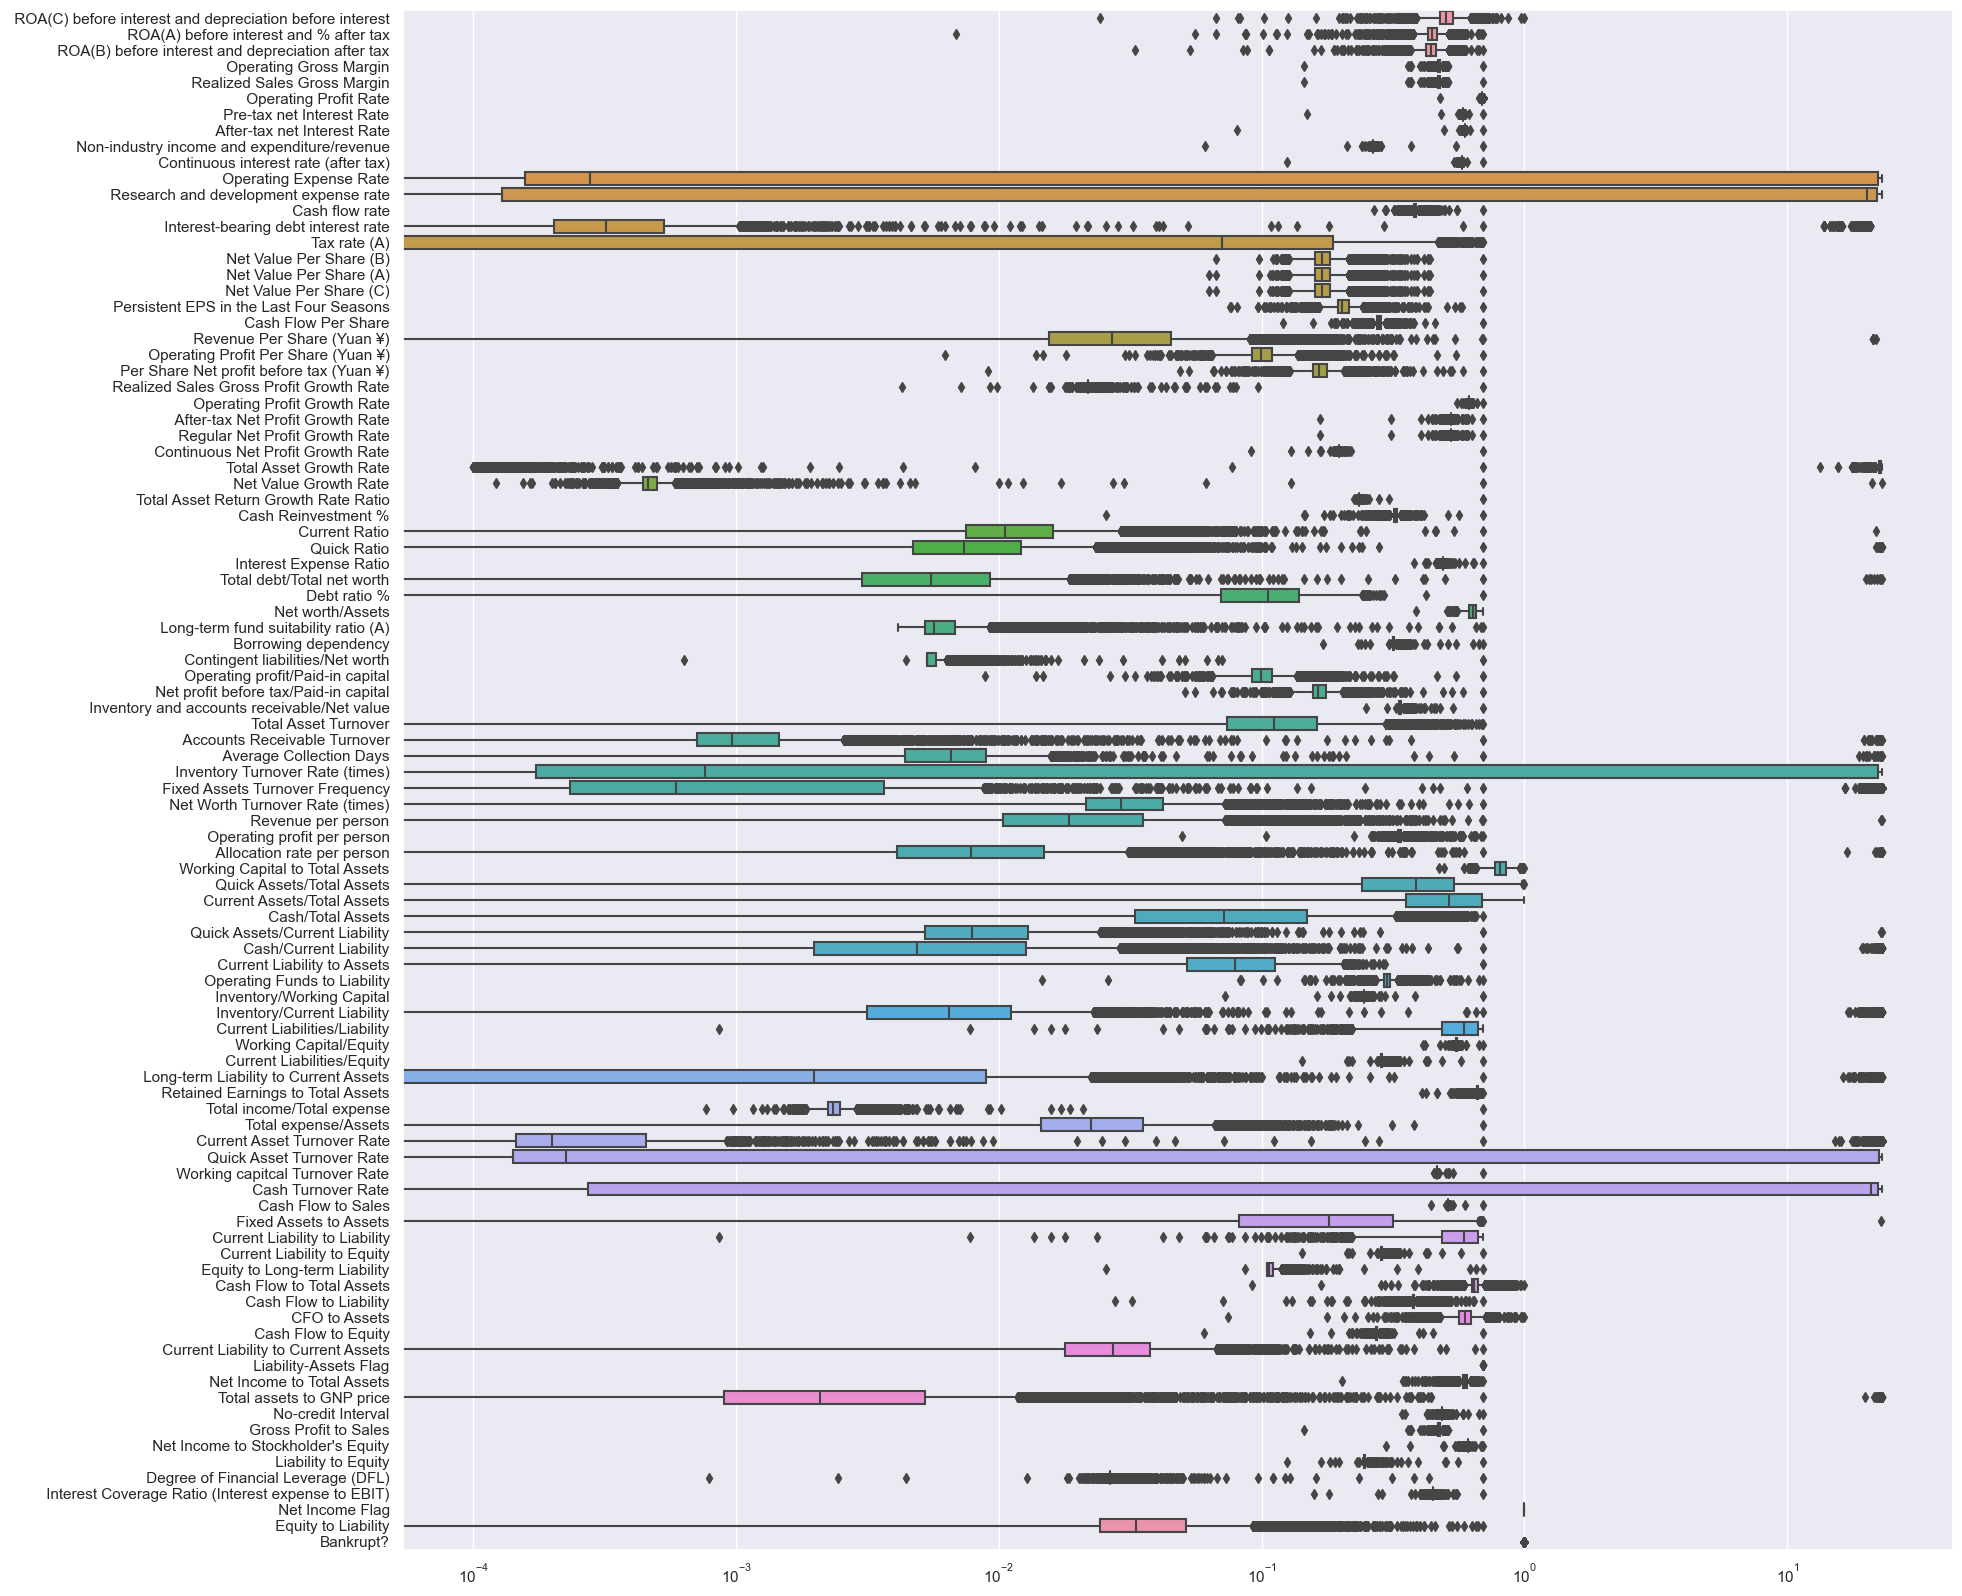

In [52]:
plt.figure(figsize=(20,20))
ax = sns.boxplot(data=df,orient='h')
ax.set(xscale='log')
sns.set()

In [53]:
# Viewing the correlation between all the numerical variables in a heatmap 

<AxesSubplot:>

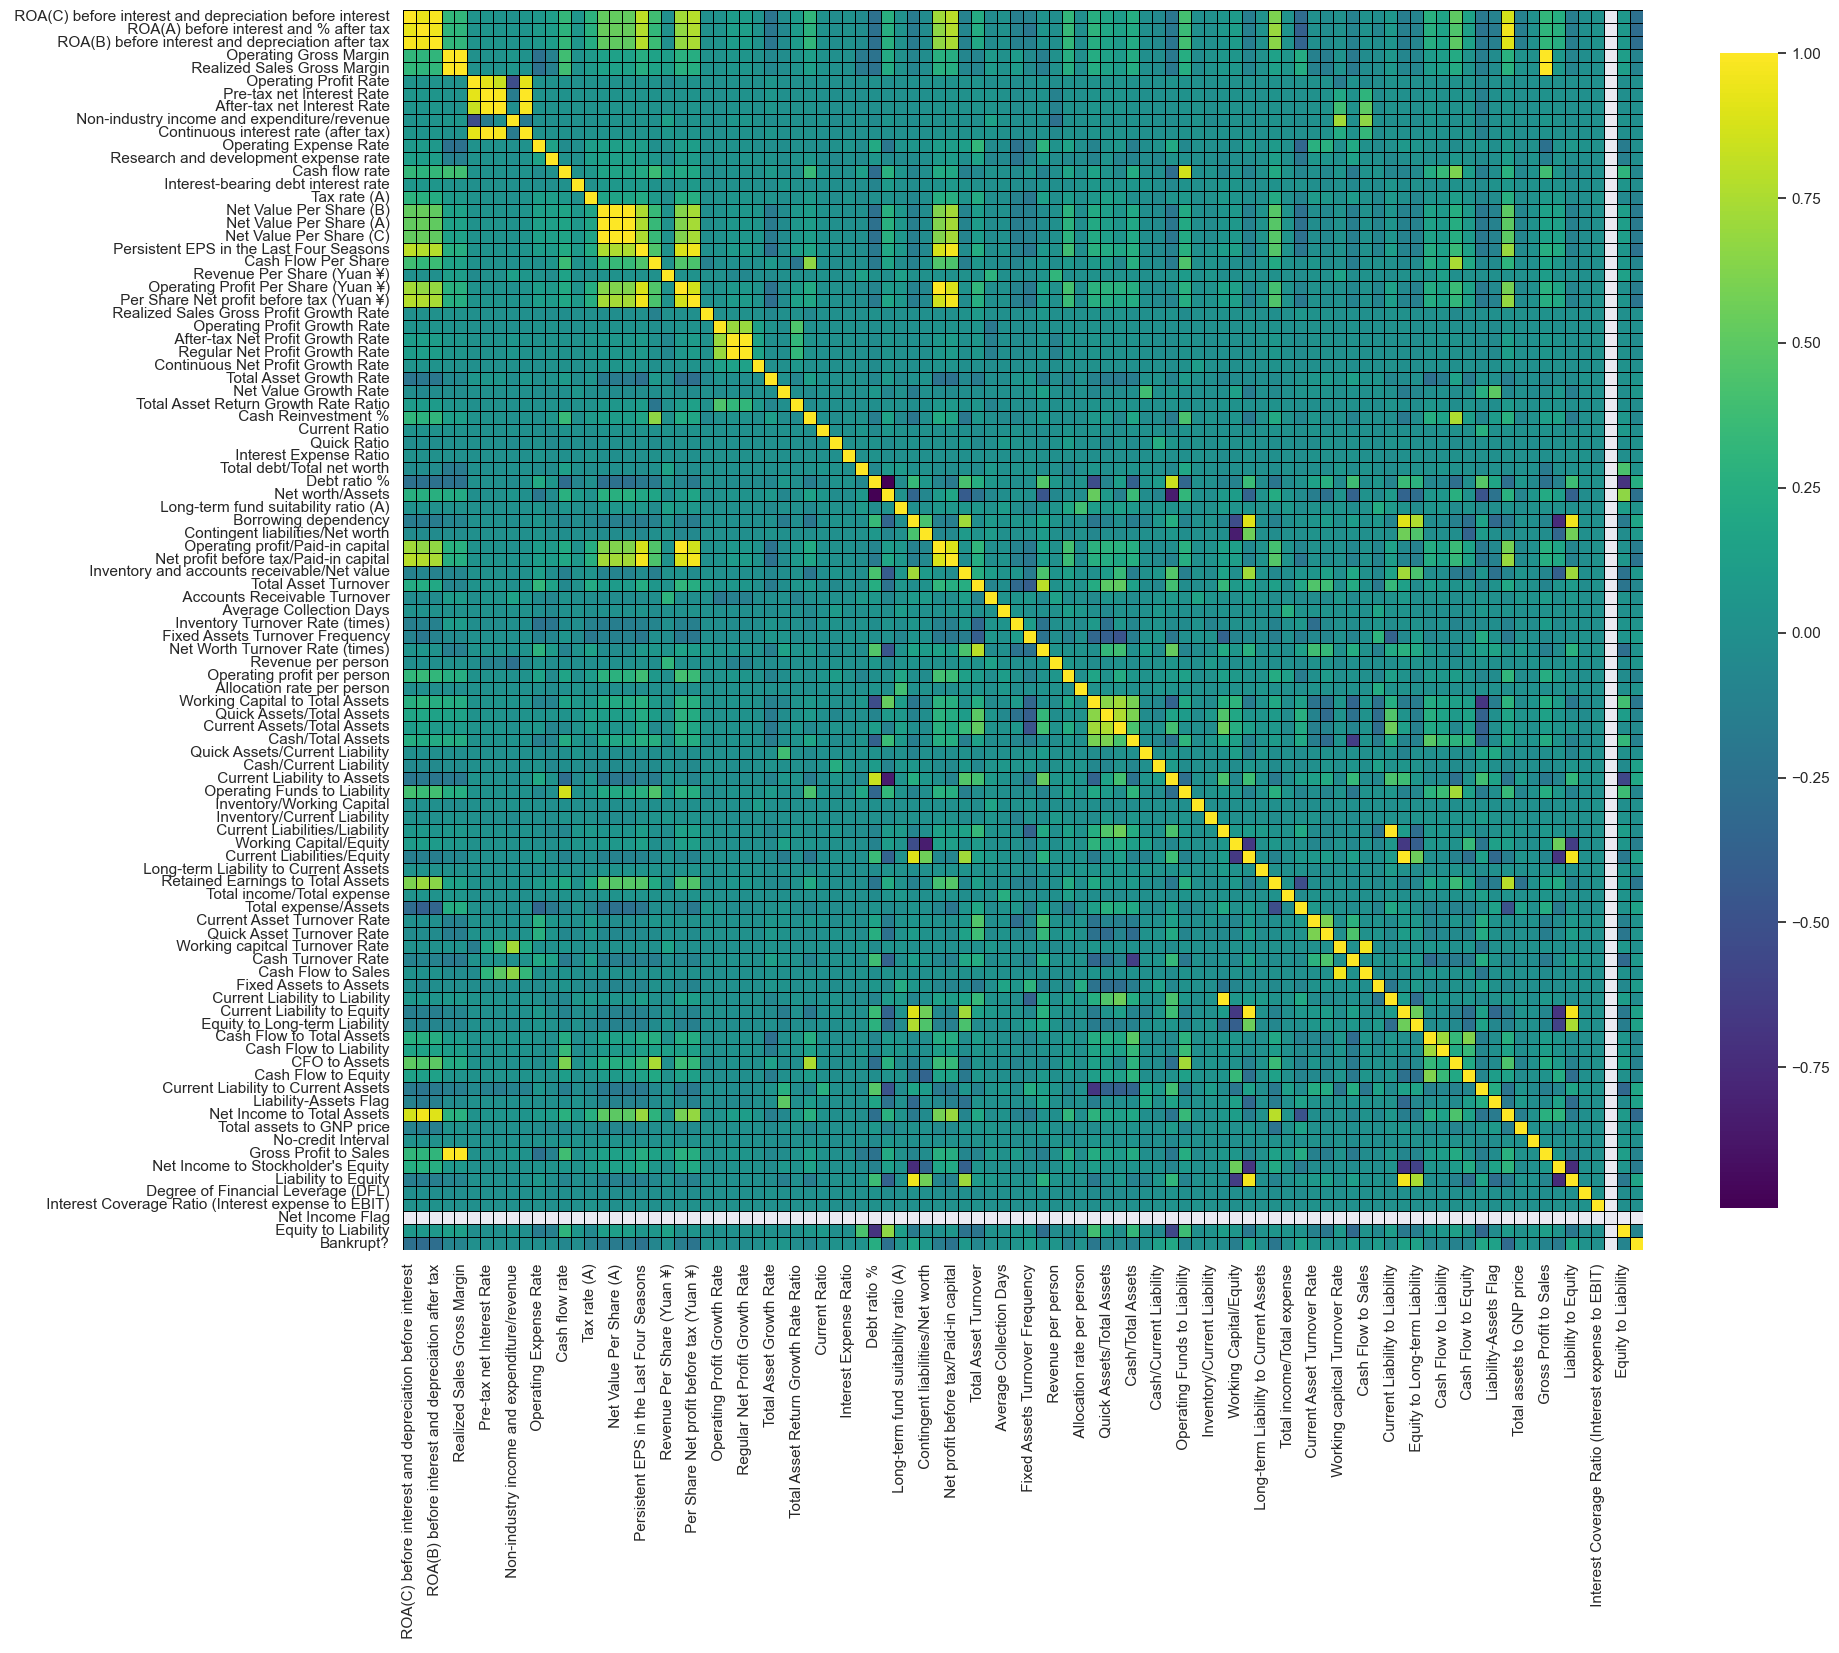

In [54]:
plt.figure(figsize=(20,20))
sns.set()
sns.heatmap(df.corr(),cmap='viridis',linewidths=0.5,linecolor='black',annot=False,square=True,cbar_kws={"shrink": .75})

In [55]:
# Creating a dataframe which contains the correlation between all the variables and the bankruptcy label

In [56]:
corr_features = pd.DataFrame(df.corr()['Bankrupt?'].drop('Bankrupt?')).reset_index()
corr_features.columns = ['ExplanatoryV','Correlation']

In [57]:
corr_features.nlargest(5,columns=['Correlation'])

,ExplanatoryV,Correlation
36,Debt ratio %,0.245965
59,Current Liability to Assets,0.193985
83,Current Liability to Current Assets,0.190760
39,Borrowing dependency,0.173175
90,Liability to Equity,0.166696


In [58]:
corr_features.nsmallest(5,columns=['Correlation'])

,ExplanatoryV,Correlation
85,Net Income to Total Assets,-0.311853
1,ROA(A) before interest and % after tax,-0.292131
2,ROA(B) before interest and depreciation after...,-0.280984
0,ROA(C) before interest and depreciation befor...,-0.260807
37,Net worth/Assets,-0.250163


In [59]:
# Boxplot displaying variable which have the highest positive correlation with bankruptcy

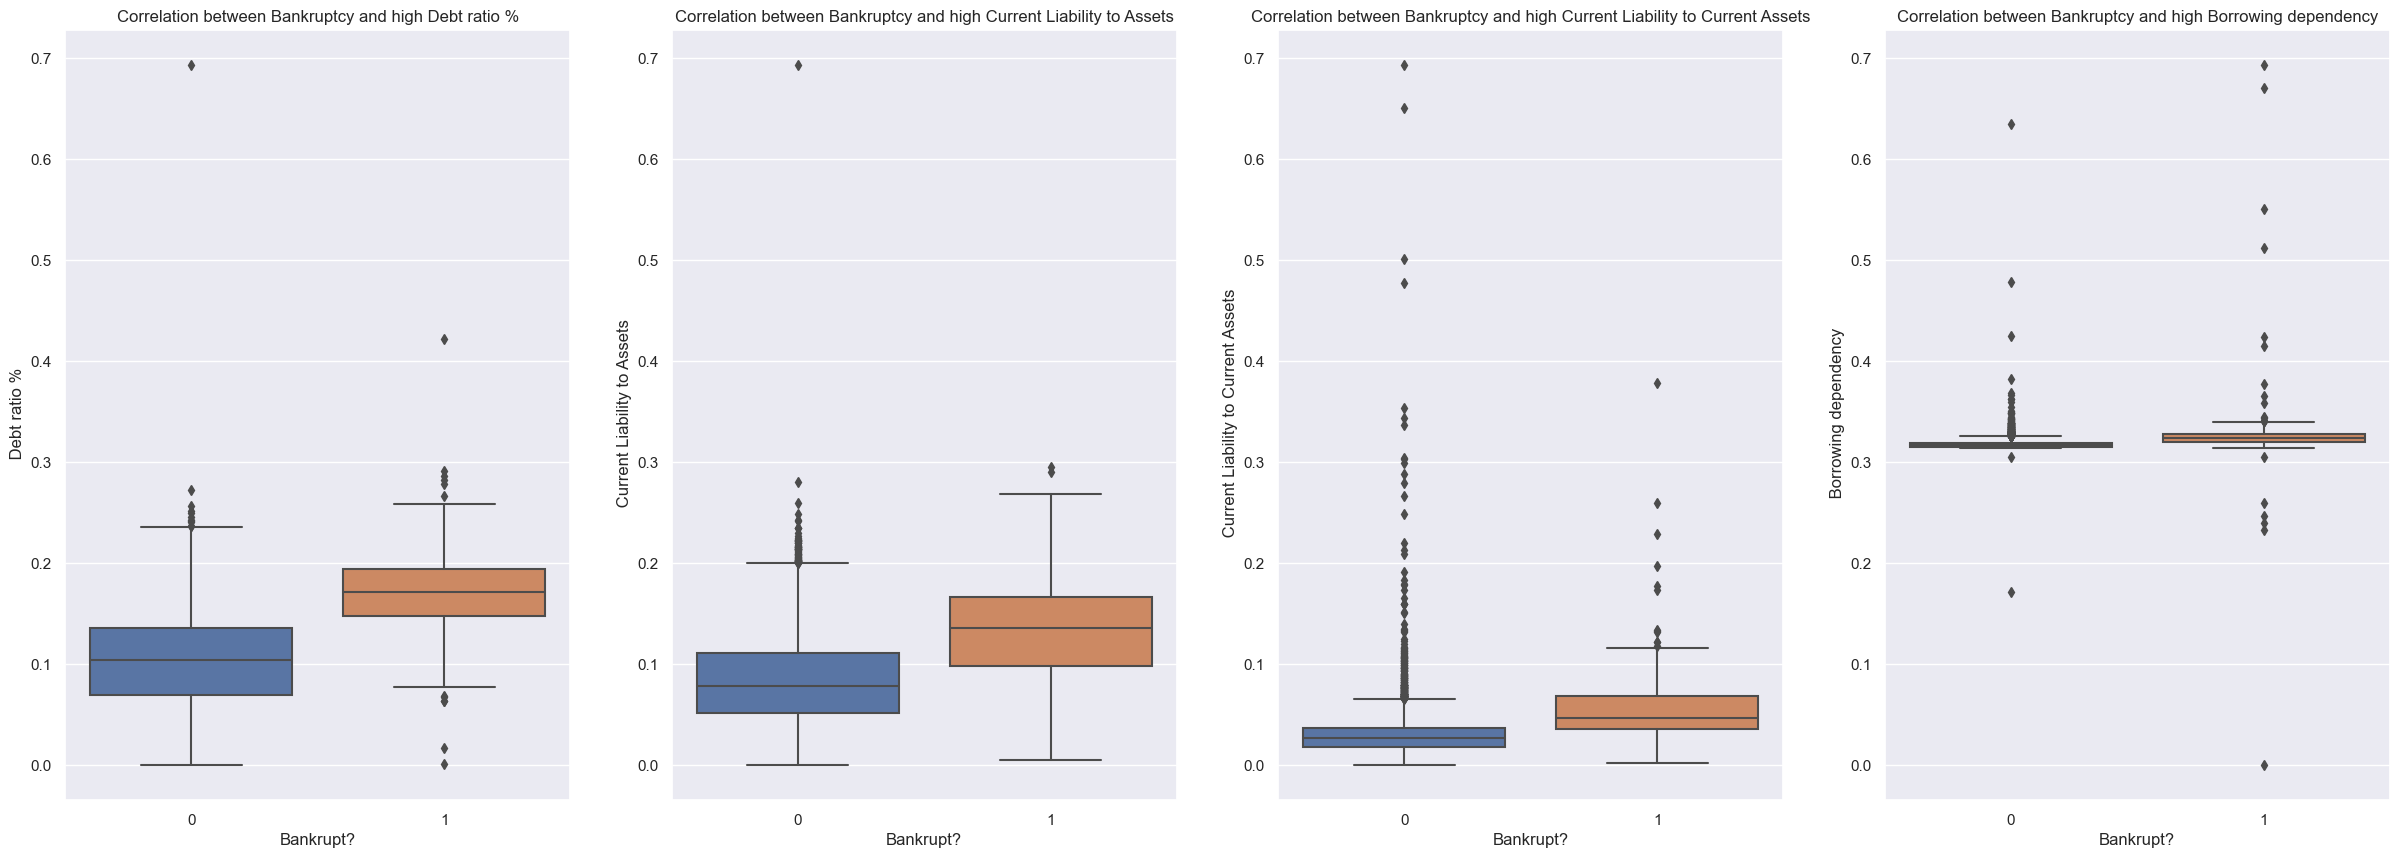

In [60]:
t = 4

pos_corr = corr_features.nlargest(t,columns=['Correlation'])['ExplanatoryV'].to_list()
fig, axes = plt.subplots(ncols=t, figsize=(30,10))

for x, feature in enumerate(pos_corr):
    sns.boxplot(data=df,x='Bankrupt?',y=feature,ax=axes[x])
    axes[x].set_title(f'Correlation between Bankruptcy and high {feature.lstrip()}')


In [61]:
# Boxplot displaying variable which have the highest negative correlation with bankruptcy

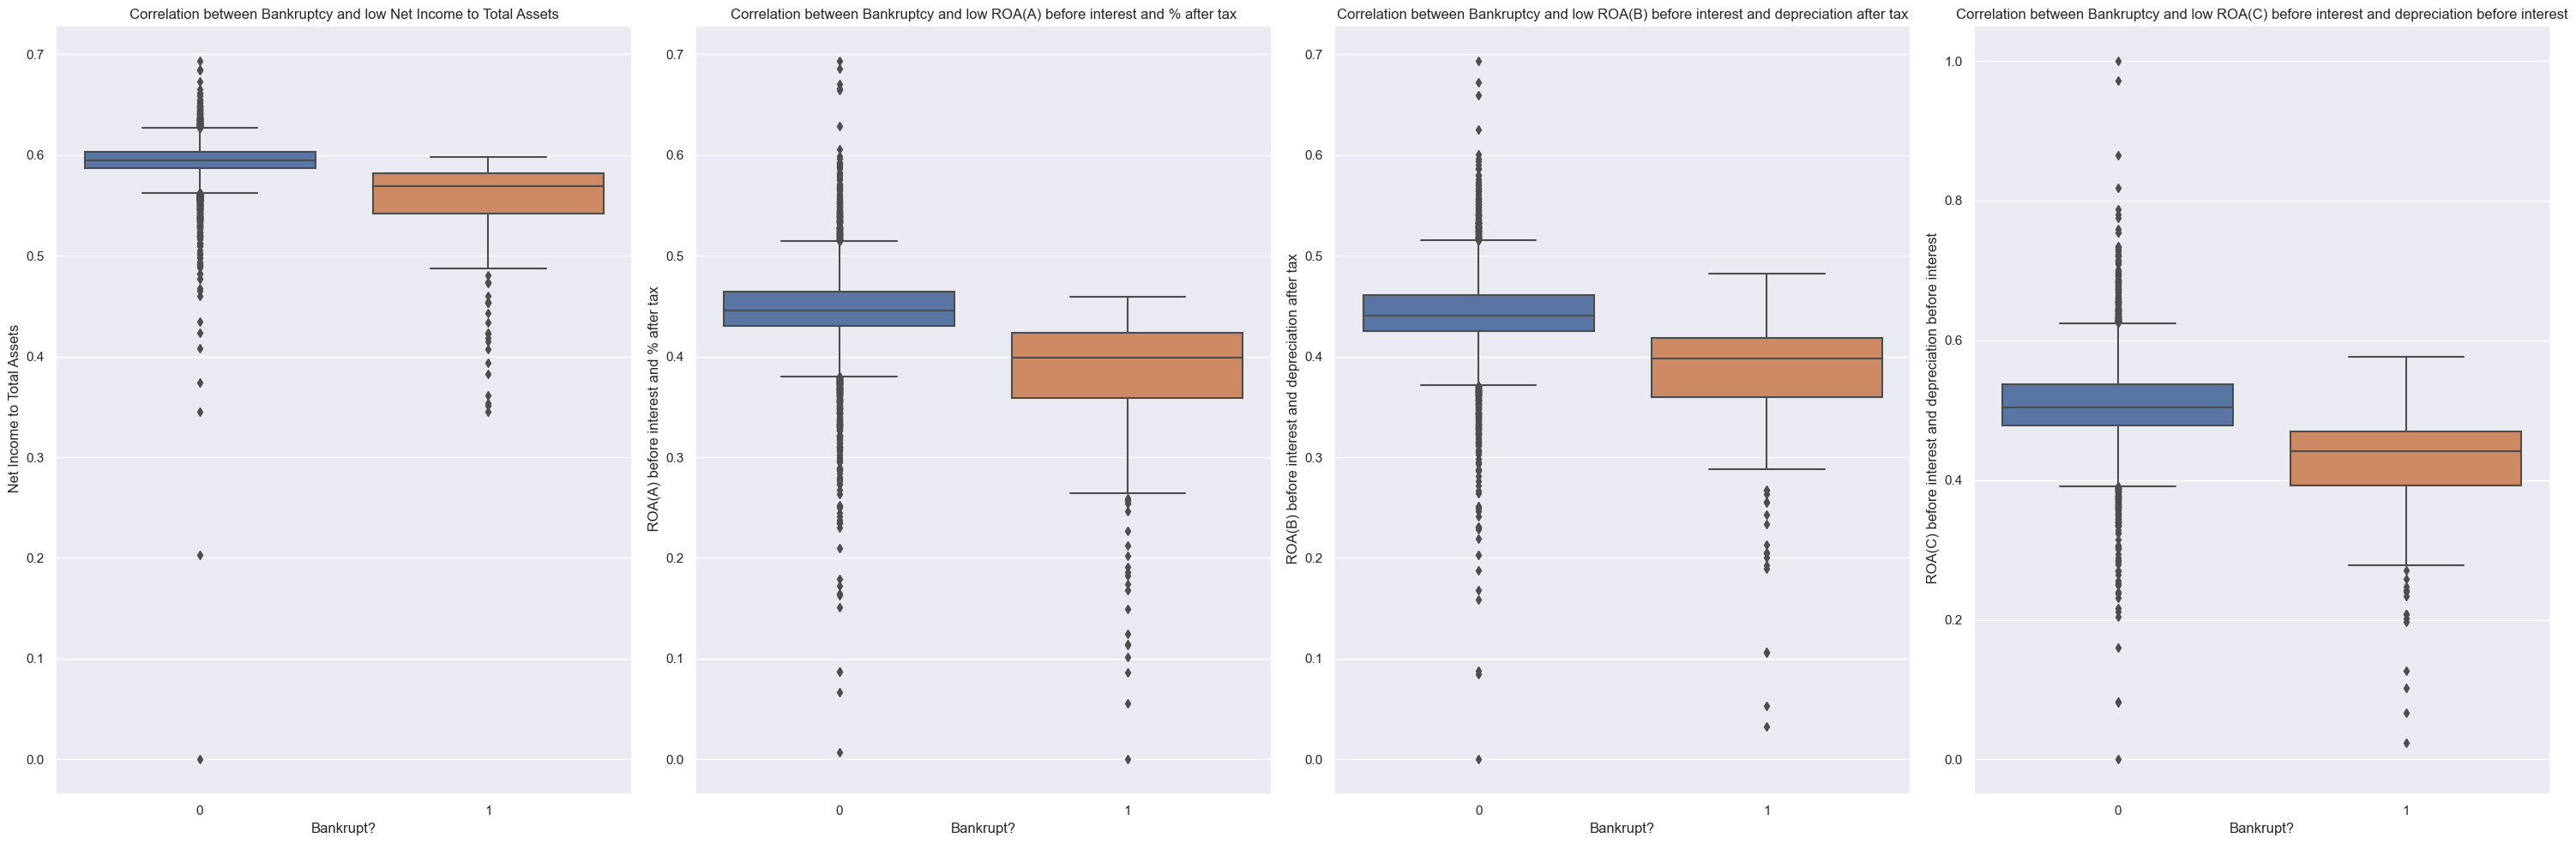

In [62]:
t = 4

neg_corr = corr_features.nsmallest(t,columns=['Correlation'])['ExplanatoryV'].to_list()
fig, axes = plt.subplots(ncols=t, figsize=(30,10))

for x, feature in enumerate(neg_corr):
    sns.boxplot(data=df,x='Bankrupt?',y=feature,ax=axes[x])
    axes[x].set_title(f'Correlation between Bankruptcy and low {feature.lstrip()}')
fig.tight_layout()

In [63]:
# Dictionary of models and parameters which will be used in the GridSearch Cross Validation process

In [64]:
model_params = {
    'Logistic':{
        'model':LogisticRegression(random_state=42),
        'params':{
            'Logistic__C':[0.001,0.1,1,2],
            'Logistic__solver':['newton-cg','sag','lbfgs','liblinear']
        }
    },
    'SVC':{
        'model':SVC(random_state=42),
        'params':{
            'SVC__C':[0.01,0.1,1,2]
        }
    },
    'DecisionTC':{
        'model':DecisionTreeClassifier(random_state=42),
        'params':{
            'DecisionTC__min_samples_split':[2,4]
        }
    },
    'RandomFC':{
        'model':RandomForestClassifier(random_state=42),
        'params':{
            'RandomFC__n_estimators':[100,140,200,300,400],
            'RandomFC__max_depth':[2,4],
            'RandomFC__min_samples_split':[2,4,6],
            'RandomFC__min_samples_leaf':[1,2]
        }
    },
    'XGBoost':{
        'model':XGBClassifier(),
        'params':{
            'XGBoost__n_estimators':[400,500,600,700]
        }
    }
}

In [65]:
from imblearn.pipeline import make_pipeline, Pipeline
import sklearn.metrics as skm 
smt = SMOTE()

X_train, X_test, y_train, y_test = train_test_split(df.drop('Bankrupt?',axis=1), df['Bankrupt?'], test_size=0.1, random_state=42)


In [66]:
# Deciding whether to use precision or recall:
# Precision is used as a metric when our objective is to minimize false positives 
# and recall is used when the objective is to minimize false negatives

In [67]:
# GridSearchCV to test multiple models and find the best performing parameters using cross validation for each model.
# Synthetic Minority Oversampling Technique (SMOTE) is used in a pipeline which means it will only balance the training data
# that the GridSearchCV makes. If the data was balanced before this point, then training data would leak into the test data,
# which would defeat the purpose of having cross validation in the Gridsearch.  

In [68]:
models_d = {}
score = []
for model_name,mp in model_params.items():
    pipeline = Pipeline([('smt',smt),(model_name,mp['model'])])
    #pipeline = make_pipeline(smt,mp['model'])
    clf = GridSearchCV(pipeline,mp['params'],cv=5,n_jobs=14,verbose=2,scoring='recall_weighted')
    clf.fit(X_train,y_train)
    score.append({
        'model':model_name,
        'best_score':clf.best_score_,
        'best_params':clf.best_params_
    })
    models_d[model_name] = clf
    print(f'{model_name} model done')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Logistic model done
Fitting 5 folds for each of 4 candidates, totalling 20 fits
SVC model done
Fitting 5 folds for each of 2 candidates, totalling 10 fits
DecisionTC model done
Fitting 5 folds for each of 60 candidates, totalling 300 fits
RandomFC model done
Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\clint\anaconda3\envs\Data_Science\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\clint\anaconda3\envs\Data_Science\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:42:12] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost model done


In [69]:
# Storing the best score and parameters for each of the tested models

In [70]:
best_df = pd.DataFrame(score,columns=['model','best_score','best_params'])

In [71]:
best_df.sort_values('best_score',ascending=False)

,model,best_score,best_params
4,XGBoost,0.967084,{'XGBoost__n_estimators': 500}
2,DecisionTC,0.938081,{'DecisionTC__min_samples_split': 4}
3,RandomFC,0.902559,"{'RandomFC__max_depth': 4, 'RandomFC__min_samp..."
0,Logistic,0.877464,"{'Logistic__C': 2, 'Logistic__solver': 'liblin..."
1,SVC,0.810168,{'SVC__C': 2}


In [72]:
# Visualising the confusion matrix for each of the 5 models 

c:\Users\clint\anaconda3\envs\Data_Science\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


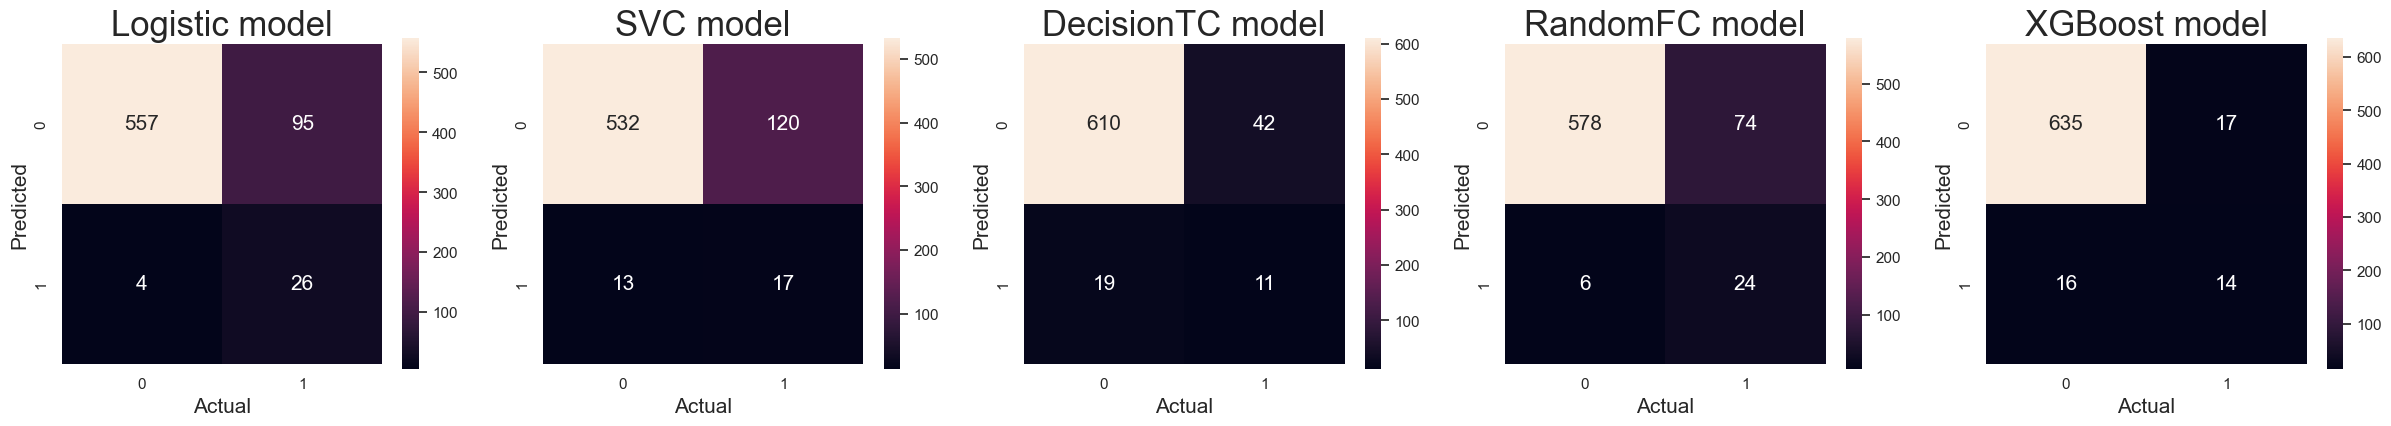

In [73]:
fig, axes = plt.subplots(ncols=5,figsize=(30,10))
models_test = []
for pos, (model_name, model) in enumerate(models_d.items()):
    pred = model.predict(X_test)
    temp_df = pd.DataFrame(confusion_matrix(y_test,pred),range(2),range(2))
    sns.heatmap(temp_df,ax=axes[pos],annot=True,square=True,fmt='g',annot_kws={"size": 15},cbar_kws={"shrink": .43})
    axes[pos].set_title(f'{model_name} model',fontsize=25)
    axes[pos].set_xlabel('Actual',fontsize=15)
    axes[pos].set_ylabel('Predicted',fontsize=15)
    
    

In [74]:
# Visualing the Precision, Recall and F1 score for each of the 5 models

c:\Users\clint\anaconda3\envs\Data_Science\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


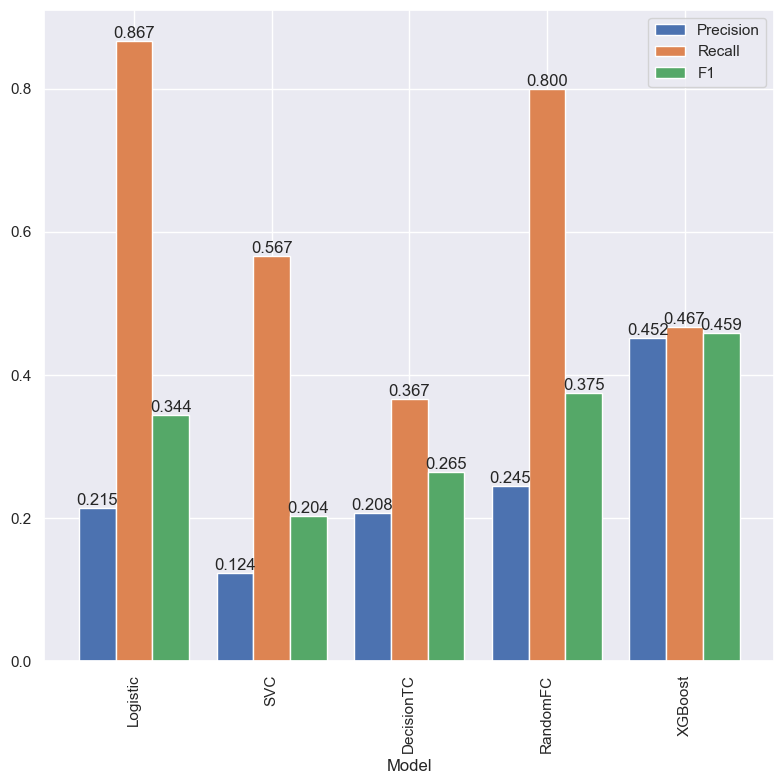

In [75]:
pod = pd.DataFrame(columns=['Model','Precision','Recall','F1'])
for model_name, model in models_d.items():
    pred = model.predict(X_test)
    f1 = f1_score(y_test,pred)
    recall = recall_score(y_test,pred)
    precision = precision_score(y_test,pred)
    pod.loc[len(pod.index)] = [model_name,precision,recall,f1]
    
fig, ax = plt.subplots(ncols=1,figsize=(8,8))
ax = pod.set_index('Model').plot(kind='bar', ax=ax, width=0.8)
for container in ax.containers:
    ax.bar_label(container,label_type='edge',fmt='%.3f')
plt.tight_layout()

In [76]:
# Trying out Seaborn's new 0.12 update which debuts the seaborn.objects interface

In [77]:
import seaborn.objects as so

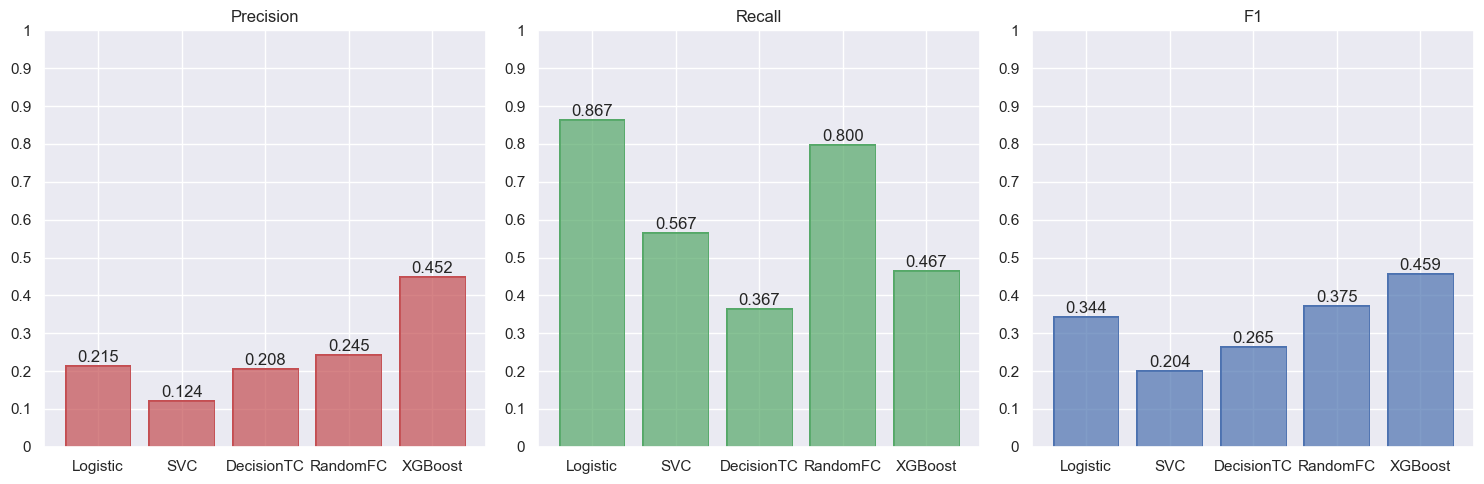

In [78]:
st = ['Precision','Recall','F1']
colors = ['r','g','b']

fig, axes = plt.subplots(ncols=3,figsize=(15,5))

for pos, (col,stat) in enumerate(zip(colors,st)):
    (
        so.Plot(data=pod,x='Model',y=stat)
        .add(so.Bar(color=col))
        .on(axes[pos])
        .scale(y=so.Continuous().tick(at=np.arange(0,1.2,0.1)))
        .label(
            title=f'{stat}',
            y='',
            x=''
            )
        .plot()
    )
    axes[pos].set_yticklabels([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.9,1])
    axes[pos].set_ylim(0,1.1)
    for container in axes[pos].containers:
        axes[pos].bar_label(container,label_type='edge',fmt='%.3f')
plt.tight_layout()